<a href="https://colab.research.google.com/github/Bhaveshsisodia/lstm_model/blob/main/LSTM_univariate_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [54]:
df = pd.read_csv("/content/drive/MyDrive/data_lstm.csv")
df.head()

,city_id,date_int,time_block,hour,iconcode,precipitation,pressurechange,pressuremeansealevel,relativehumidity,temperature,...,visibility,winddirection,windgust,windspeed,demand,month,year,day_of_week,day_of_year,day_of_month
0,7,20240101,24,6,20.0,0.0,0.30,1017.90,93.70,9.70,...,0.13,40.0,0.0,2.50,1638.00,1,2024,0,1,1
1,7,20240101,25,7,20.0,0.0,0.45,1018.18,91.25,9.57,...,0.35,37.5,0.0,3.32,1731.75,1,2024,0,1,1
2,7,20240101,26,7,20.0,0.0,0.60,1018.45,88.80,9.45,...,0.56,35.0,0.0,4.15,1832.87,1,2024,0,1,1
3,7,20240101,27,7,20.0,0.0,0.75,1018.72,86.35,9.32,...,0.78,32.5,0.0,4.97,1932.22,1,2024,0,1,1
4,7,20240101,28,7,20.0,0.0,0.90,1019.00,83.90,9.20,...,1.00,30.0,0.0,5.80,2021.00,1,2024,0,1,1


In [55]:
df['Date'] =pd.to_datetime(df['date_int'],format="%Y%m%d")

In [56]:
max(df['date_int']), min(df['date_int'])

(20250502, 20240101)

In [57]:
train_df = df[(df['date_int'] >= 20241001) & (df['date_int'] <= 20250131)]
test_df = df[(df['date_int'] >= 20250201) & (df['date_int'] <= 20250228)]

In [58]:
model_data = train_df[train_df['city_id']==7]
model_data_test = test_df[test_df['city_id']==7]

In [59]:
model_data=model_data[['date_int','time_block','demand']]
model_data_test=model_data_test[['date_int','time_block','demand']]

In [60]:
# Combine date and block number to datetime (15-min intervals)
model_data['Datetime'] = pd.to_datetime(model_data['date_int'],format="%Y%m%d") + pd.to_timedelta((model_data['time_block'] - 1) * 15, unit='m')


model_data_test['Datetime'] = pd.to_datetime(model_data_test['date_int'],format="%Y%m%d") + pd.to_timedelta((model_data_test['time_block'] - 1) * 15, unit='m')

In [61]:
model_data_test

,date_int,time_block,demand,Datetime
257123,20250201,1,1559.60,2025-02-01 00:00:00
257124,20250201,2,1547.02,2025-02-01 00:15:00
257125,20250201,3,1537.43,2025-02-01 00:30:00
257126,20250201,4,1528.00,2025-02-01 00:45:00
257127,20250201,5,1518.23,2025-02-01 01:00:00
...,...,...,...,...
275358,20250228,92,1453.00,2025-02-28 22:45:00
275359,20250228,93,1429.03,2025-02-28 23:00:00
275360,20250228,94,1405.78,2025-02-28 23:15:00
275361,20250228,95,1384.74,2025-02-28 23:30:00


In [62]:
model_data = model_data[['Datetime', 'demand']]
model_data.set_index('Datetime', inplace=True)

In [63]:
model_data_test = model_data_test[['Datetime', 'demand']]
model_data_test.set_index('Datetime', inplace=True)

In [64]:
model_data

,demand
Datetime,
2024-10-01 00:00:00,1916.60
2024-10-01 00:15:00,1907.37
2024-10-01 00:30:00,1899.85
2024-10-01 00:45:00,1889.00
2024-10-01 01:00:00,1873.92
...,...
2025-01-31 22:45:00,1710.00
2025-01-31 23:00:00,1669.07
2025-01-31 23:15:00,1633.14


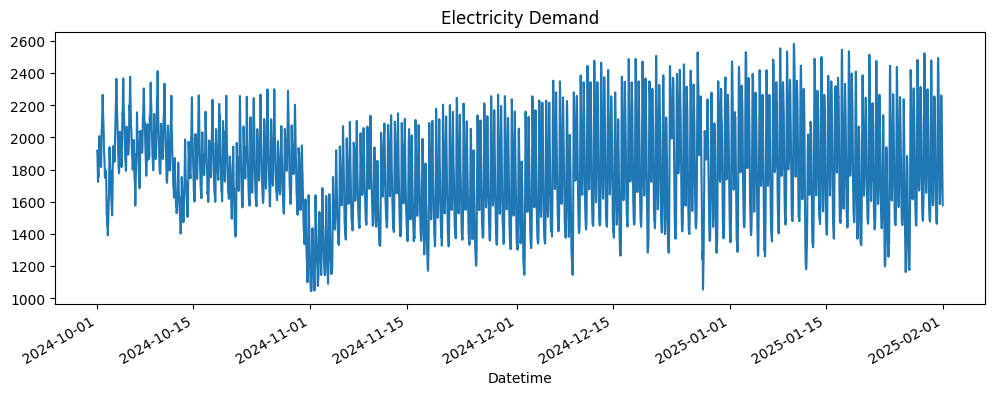

In [65]:
model_data = model_data.sort_index()

# Plot the demand
model_data['demand'].plot(figsize=(12, 4), title='Electricity Demand')
plt.show()

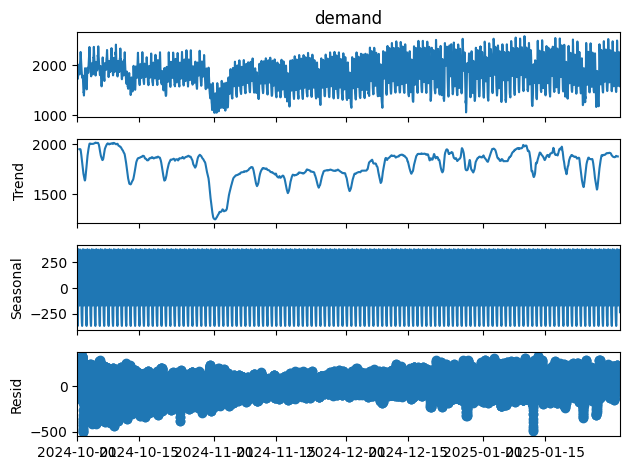

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(model_data['demand'], model='additive', period=96)  # 96 blocks per day
result.plot()
plt.show()


In [67]:
model_data

,demand
Datetime,
2024-10-01 00:00:00,1916.60
2024-10-01 00:15:00,1907.37
2024-10-01 00:30:00,1899.85
2024-10-01 00:45:00,1889.00
2024-10-01 01:00:00,1873.92
...,...
2025-01-31 22:45:00,1710.00
2025-01-31 23:00:00,1669.07
2025-01-31 23:15:00,1633.14


In [68]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(model_data)

In [69]:
test_scaled = scaler.transform(model_data_test)



In [70]:
train_scaled

array([[0.56752588],
       [0.56151939],
       [0.55662569],
       ...,
       [0.38306208],
       [0.36322698],
       [0.34717929]])

In [71]:
# Function to create input-output sequences
def create_sequences(data, window_size=96):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Window size = 1 day = 96 blocks
window_size = 96
X_train, y_train = create_sequences(train_scaled, window_size)

X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [73]:
X_train

array([[[0.56752588],
        [0.56151939],
        [0.55662569],
        ...,
        [0.59855402],
        [0.58026772],
        [0.56583391]],

       [[0.56151939],
        [0.55662569],
        [0.54956497],
        ...,
        [0.58026772],
        [0.56583391],
        [0.55644999]],

       [[0.55662569],
        [0.54956497],
        [0.53975154],
        ...,
        [0.56583391],
        [0.55644999],
        [0.55092505]],

       ...,

       [[0.39789935],
        [0.37945037],
        [0.36214672],
        ...,
        [0.46279943],
        [0.43307932],
        [0.4064438 ]],

       [[0.37945037],
        [0.36214672],
        [0.34570858],
        ...,
        [0.43307932],
        [0.4064438 ],
        [0.38306208]],

       [[0.36214672],
        [0.34570858],
        [0.33040926],
        ...,
        [0.4064438 ],
        [0.38306208],
        [0.36322698]]])

In [23]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0342 - val_loss: 0.0024
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0019 - val_loss: 7.9340e-04
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.2674e-04 - val_loss: 3.5624e-04
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.1196e-04 - val_loss: 2.0645e-04
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8323e-04 - val_loss: 1.6502e-04
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.0654e-04 - val_loss: 1.3994e-04
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.6734e-04 - val_loss: 2.1264e-04
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4654e-04 - val_loss: 9.8015e-05
Epoch 9/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1170e-04 - val_loss: 1.6663e-04
Epoch 10/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.8530e-05 - val_loss: 1.2740e-04


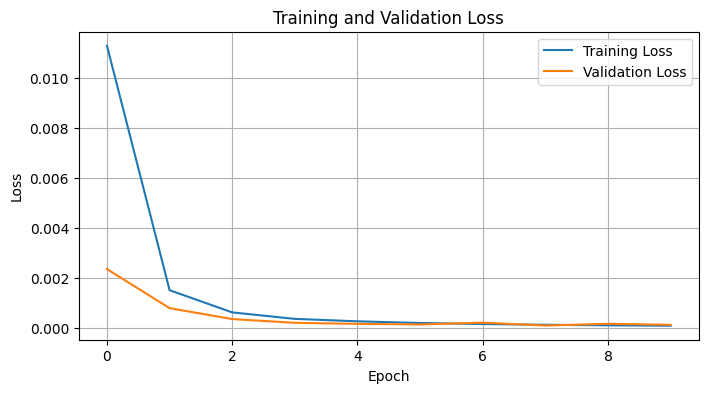

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Predict
predicted_scaled = model.predict(X_test)

# Inverse transform
predicted = scaler.inverse_transform(predicted_scaled)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
len(y_test_true)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


2592

In [74]:
len(predicted)

2592

In [47]:
df_test =pd.concat([pd.DataFrame(y_test_true,columns=['Actual']), pd.DataFrame(predicted,columns=['Predicted'])],axis=1)

<Axes: >

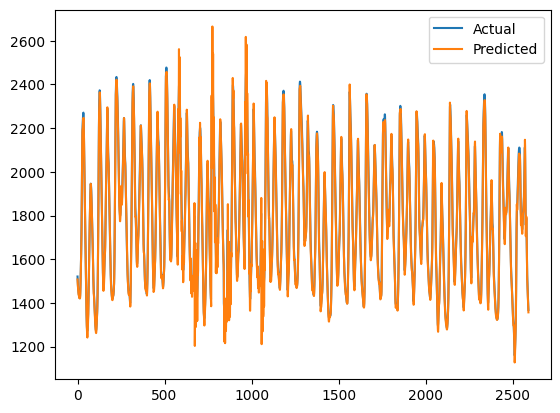

In [85]:
df_test[:].plot()

In [86]:
model_data_test

,demand
Datetime,
2025-02-01 00:00:00,1559.60
2025-02-01 00:15:00,1547.02
2025-02-01 00:30:00,1537.43
2025-02-01 00:45:00,1528.00
2025-02-01 01:00:00,1518.23
...,...
2025-02-28 22:45:00,1453.00
2025-02-28 23:00:00,1429.03
2025-02-28 23:15:00,1405.78


In [87]:
df_final=pd.concat([model_data_test[96:].reset_index(),pd.DataFrame(predicted,columns=['Predicted'])],axis=1)

In [89]:
df_final

,Datetime,demand,Predicted
0,2025-02-02 00:00:00,1521.06,1507.525146
1,2025-02-02 00:15:00,1501.85,1488.931396
2,2025-02-02 00:30:00,1486.76,1478.675293
3,2025-02-02 00:45:00,1474.00,1468.639893
4,2025-02-02 01:00:00,1463.06,1455.681519
...,...,...,...
2587,2025-02-28 22:45:00,1453.00,1447.919922
2588,2025-02-28 23:00:00,1429.03,1422.182983
2589,2025-02-28 23:15:00,1405.78,1397.700073
2590,2025-02-28 23:30:00,1384.74,1376.093384


In [93]:
def daily_mape(group):
    return np.mean(np.abs((group['demand'] - group['Predicted']) / group['demand'])) * 100

# Compute daily MAPE
daily_mape_values = df_final.groupby('Datetime').apply(daily_mape)

<ipython-input-93-1b5e0cc03b29>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_mape_values = df_final.groupby('Datetime').apply(daily_mape)


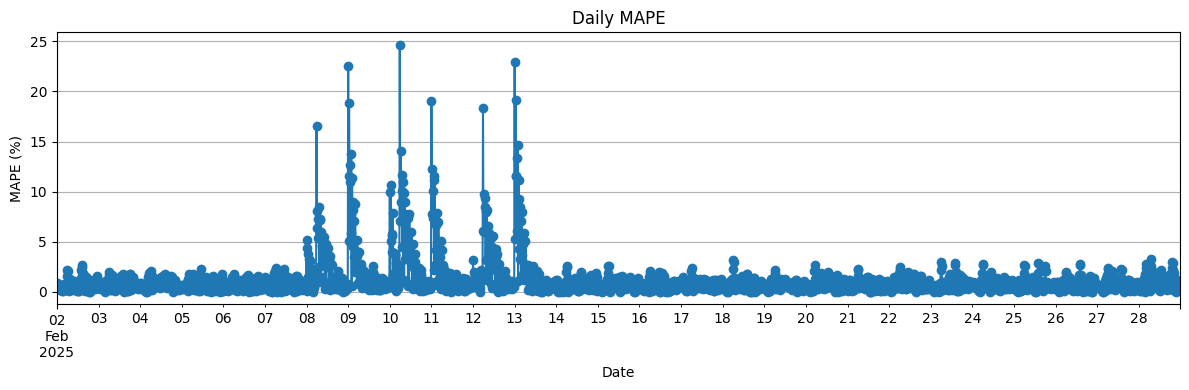

Average MAPE for February: 1.16%


In [94]:

# Plot daily MAPE
plt.figure(figsize=(12, 4))
daily_mape_values.plot(marker='o')
plt.title("Daily MAPE")
plt.ylabel("MAPE (%)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: print average MAPE over the month
print(f"Average MAPE for February: {daily_mape_values.mean():.2f}%")

In [102]:
daily_mape_values=daily_mape_values.reset_index()

In [105]:
daily_mape_values['Date'] = daily_mape_values['Datetime'].dt.date
daily_mape_values['Time'] = daily_mape_values['Datetime'].dt.time

# Reorder columns (optional)
daily_mape_values = daily_mape_values[['Datetime', 'Date', 'Time', 0]]

In [111]:
daily_mape_values[['Date',0]].groupby(['Date']).mean()

,0
Date,
2025-02-02,0.757312
2025-02-03,0.765004
2025-02-04,0.811820
2025-02-05,0.735959
2025-02-06,0.689836
2025-02-07,0.764366
2025-02-08,2.245475
2025-02-09,2.575625
2025-02-10,3.355823
